In [1]:
import os, random, itertools, warnings
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import clone_model
from tensorflow.keras import layers, Model

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

### Configurations

In [2]:
SEED        = 42
N_CLUSTERS  = 3         # number of clusters for IDEC
LATENT_DIM  = 30        # dimension of autoencoder's bottleneck
AE_EPOCHS   = 50        # epochs to pretrain the autoencoder
IDEC_EPOCHS = 30        # epochs to train IDEC after initialization
BATCH_SIZE  = 256       # batch size for training

# Grid of (alpha, kl_weight) to scan
ALPHAS      = [5, 8]
KL_WEIGHTS  = [0.08, 0.15, 0.2]

# Features for visualizations
TOP_K_FEATURES  = 10
pd.set_option("display.max_columns", 50)

In [3]:
# Set random seeds for reproducibility
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

### Data Loading

In [4]:
DATA_PATH = "./Data/telecom_preprocessed.csv"
ORIG_PATH = "./Data/Telecom/Telecom_customer_dataset.csv"

In [35]:
df_raw = pd.read_csv(DATA_PATH)
df_orig = pd.read_csv(ORIG_PATH)
df_orig = df_orig.drop(columns=["Customer_ID","churn"])
df_scaled = df_raw.copy() #preprocessed data copied and named as scaled to avoid changing the original and to show it is scaled

In [6]:
X = df_raw.values.astype("float32")
X_scaled = df_scaled.values
N, D = X.shape

### Helpers

In [7]:
def metric_report(z, labels, tag=""):
    sil = silhouette_score(z, labels)
    dbi = davies_bouldin_score(z, labels)
    chi = calinski_harabasz_score(z, labels)
    print(f"{tag:>15s}  Sil={sil:.3f}  DBI={dbi:.3f}  CHI={chi:.1f}")

In [8]:
def make_contingency(labels_ref, labels_tgt, k):
    idx = labels_ref * k + labels_tgt
    return np.bincount(idx, minlength=k*k).reshape(k, k)

In [9]:
def clustering_metrics(X: np.ndarray, labels: np.ndarray) -> Dict[str, float]:
    uniq = np.setdiff1d(np.unique(labels), [-1])
    if len(uniq) < 2:
        return dict(silhouette=np.nan, davies=np.nan, calinski=np.nan)
    return dict(
        silhouette=silhouette_score(X, labels),
        davies=davies_bouldin_score(X, labels),
        calinski=calinski_harabasz_score(X, labels),
    )

In [10]:
def cluster_summary(df: pd.DataFrame, labels: np.ndarray,
                    top_k_features: int = TOP_K_FEATURES) -> pd.DataFrame:
    labelled = df.copy()
    labelled["cluster"] = labels
    variances = (
        labelled.groupby("cluster")
        .var(numeric_only=True)
        .median()
        .sort_values(ascending=False)
    )
    feats = variances.head(top_k_features).index.tolist()
    summary = (
        labelled.groupby("cluster")[feats]
        .agg(["count", "mean", "std", "min", "max"])
        .swaplevel(axis=1)
        .sort_index(axis=1, level=0)
    )
    return summary

In [11]:
def top_variable(df: pd.DataFrame, labels: np.ndarray,
                 n_features: int = TOP_K_FEATURES) -> Dict[int, List[str]]:
    labelled = df.copy()
    labelled["cluster"] = labels
    num_cols = labelled.select_dtypes(include="number").columns.difference(["cluster"])
    out: Dict[int, List[str]] = {}
    for cid, grp in labelled.groupby("cluster"):
        out[cid] = (
            grp[num_cols].var().sort_values(ascending=False).head(n_features).index.tolist()
        )
    return out

In [12]:
def show_summary(summary: pd.DataFrame, caption: str = "Cluster summary"):
    sty = (
        summary.style
        .set_caption(caption)
        .background_gradient(axis=None, cmap="Blues", vmin=summary.min().min())
        .format(precision=2)
    )
    display(sty)
    return sty

In [13]:
def plot_pca(X: np.ndarray, labels: np.ndarray, title: str = "PCA Projection"):
    pca = PCA(n_components=2, random_state=SEED)
    coords = pca.fit_transform(X)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=coords[:, 0], y=coords[:, 1], hue=labels,
                    palette="tab10", s=60, edgecolor="k")
    plt.title(title)
    plt.xlabel("PC 1"); plt.ylabel("PC 2"); plt.tight_layout(); plt.show()

In [14]:
def plot_tsne(X: np.ndarray, labels: np.ndarray,
              title: str = "t-SNE Projection", perplexity: int = 30, lr: int = 200):
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=lr,
                random_state=SEED, init="pca")
    coords = tsne.fit_transform(X)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=coords[:, 0], y=coords[:, 1], hue=labels,
                    palette="tab10", s=60, edgecolor="k")
    plt.title(title)
    plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2"); plt.tight_layout(); plt.show()

In [15]:
def plot_cluster_heatmap(df: pd.DataFrame, labels: np.ndarray,
                         top_features: List[str], title: str = "Feature Heatmap"):
    dfc = df[top_features].copy()
    dfc["cluster"] = labels
    heat = dfc.groupby("cluster").median()
    plt.figure(figsize=(10, 6))
    sns.heatmap(heat, annot=True, fmt=".2f", cmap="viridis")
    plt.title(title); plt.tight_layout(); plt.show()

In [16]:
def plot_feature_boxplots(df: pd.DataFrame, labels: np.ndarray,
                          features: List[str], n: int = 5):
    dfc = df.copy(); dfc["cluster"] = labels
    for feat in features[:n]:
        plt.figure(figsize=(6, 4))
        sns.boxplot(x="cluster", y=feat, data=dfc, palette="tab10")
        plt.title(f"{feat} Distribution by Cluster")
        plt.tight_layout(); plt.show()

In [17]:
def plot_parallel_coordinates(df: pd.DataFrame, labels: np.ndarray,
                              features: List[str], sample_size: int = 1000,
                              title: str = "Parallel Co-ordinate Plot"):
    sample = df[features].copy()
    sample["cluster"] = labels
    if len(sample) > sample_size:
        sample = sample.sample(sample_size, random_state=SEED)
    plt.figure(figsize=(10, 6))
    pd.plotting.parallel_coordinates(sample, "cluster", colormap="tab10", alpha=0.4)
    plt.title(title); plt.tight_layout(); plt.show()

In [18]:
def plot_radar_chart(df: pd.DataFrame, labels: np.ndarray,
                     features: List[str], title: str = "Cluster Radar Chart"):
    centroids = df[features].assign(cluster=labels).groupby("cluster").median()
    cats = list(centroids.columns)
    angles = np.linspace(0, 2*np.pi, len(cats), endpoint=False).tolist()
    angles += angles[:1]
    plt.figure(figsize=(8, 8))
    for cid in centroids.index:
        vals = centroids.loc[cid].tolist(); vals += vals[:1]
        plt.polar(angles, vals, marker="o", label=f"Cluster {cid}")
    plt.xticks(angles[:-1], cats, fontsize=8); plt.title(title, y=1.08)
    plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout(); plt.show()

## Hybrid Autoencoder-Ensemble Model

### Autoencoders Training

In [19]:
# Build a simple symmetric deep autoencoder
inp = tf.keras.Input(shape=(D,), name="AE_Input")

# Encoder layers
h = tf.keras.layers.Dense(64, activation="relu")(inp)
h = tf.keras.layers.Dense(32, activation="relu")(h)
latent = tf.keras.layers.Dense(LATENT_DIM, activation=None, name="latent")(h)

# Decoder layers
h2 = tf.keras.layers.Dense(32, activation="relu")(latent)
h2 = tf.keras.layers.Dense(64, activation="relu")(h2)
out = tf.keras.layers.Dense(D, activation="linear")(h2)

ae      = tf.keras.Model(inputs=inp, outputs=out, name="Autoencoder")
encoder = tf.keras.Model(inputs=inp, outputs=latent, name="Encoder")

ae.compile(optimizer="adam", loss="mse")

In [20]:
# Train the autoencoder
print("Pretraining Autoencoder")
ae.fit(
    X, X,
    epochs=AE_EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_split=0.2,
    verbose=0
)
print("Autoencoder pretraining complete.")

Pretraining Autoencoder
Autoencoder pretraining complete.


### Define IDEC Class

In [21]:
class IDEC(tf.keras.Model):
    """
    IDEC (Improved Deep Embedded Clustering) model.
    Combines reconstruction loss of an autoencoder with a KL-divergence 
    clustering objective to refine cluster centers in latent space.
    """
    def __init__(self, autoencoder: tf.keras.Model, encoder: tf.keras.Model,
                 centers: np.ndarray, alpha: float = 10.0, kl_weight: float = 0.1):
        super().__init__()
        self.autoencoder = autoencoder
        self.encoder     = encoder
        self.alpha       = alpha
        self.klw         = kl_weight
        # Initialize cluster centers as a trainable variable
        self.centers = tf.Variable(centers, dtype=tf.float32, name="cluster_centers")

    def target_distribution(self, q: tf.Tensor):
        """
        Compute the target distribution p_ij from soft assignments q_ij:
          p_ij = (q_ij^2 / f_j) / sum_i (q_ij^2 / f_j)
        where f_j = sum_i q_ij.
        """
        weight = (q ** 2) / tf.reduce_sum(q, axis=0)
        return weight / tf.reduce_sum(weight, axis=1, keepdims=True)

    def compile(self, optimizer):
        """
        Set up losses and optimizer.
        """
        super().compile()
        self.opt = optimizer
        self.mse = tf.keras.losses.MeanSquaredError()
        self.kld = tf.keras.losses.KLDivergence()

    def soft_assign(self, z: np.ndarray) -> tf.Tensor:
        """
        Compute Student’s t-distribution-based soft assignments:
          q_ij = (1 + ||z_i - u_j||^2 / alpha)^(- (alpha+1)/2)
        but here simplified to: num / sum(num).
        """
        diff     = tf.expand_dims(z, axis=1) - self.centers  # shape (N, k, latent_dim)
        dist_sq  = tf.reduce_sum(diff ** 2, axis=2)            # shape (N, k)
        num      = 1.0 / (1.0 + dist_sq / self.alpha)
        q        = num / tf.reduce_sum(num, axis=1, keepdims=True)
        return q

    def train_step(self, x):
        """
        One training step: 
        - Get latent z = encoder(x)
        - Reconstruct x_rec = autoencoder(x)
        - Compute q = soft_assign(z), p = target_distribution(q)
        - Compute reconstruction loss + kl_weight * KL(p || q)
        - Backpropagate through AE weights and cluster centers.
        """
        with tf.GradientTape() as tape:
            z       = self.encoder(x, training=True)
            x_rec   = self.autoencoder(x, training=True)

            # Soft assignments
            diff    = tf.expand_dims(z, 1) - self.centers
            dist_sq = tf.reduce_sum(diff ** 2, axis=2)
            num     = 1.0 / (1.0 + dist_sq / self.alpha)
            q       = num / tf.reduce_sum(num, axis=1, keepdims=True)
            p       = self.target_distribution(q)

            # Losses
            recon_loss = self.mse(x, x_rec)
            kl_loss    = self.kld(p, q)
            loss       = recon_loss + self.klw * kl_loss

        grads = tape.gradient(loss, 
                              self.autoencoder.trainable_weights + [self.centers])
        self.opt.apply_gradients(
            zip(grads, self.autoencoder.trainable_weights + [self.centers])
        )

        return {"loss": loss, "recon_loss": recon_loss, "kl_loss": kl_loss}

### Base Model Preparation for Grid Search

In [22]:
# Clone the pretrained AE and encoder so we can re-initialize fresh copies each run
ae_base      = clone_model(ae)
ae_base.set_weights(ae.get_weights())

encoder_base = clone_model(encoder)
encoder_base.set_weights(encoder.get_weights())

### Grid Search over alpha and kl_weight

In [23]:
results   = []  # to store metrics for each run
run_store = []  # to store all soft assignments, latent z, labels, metrics, & hyperparams

print("\n--- Beginning Grid Search over (alpha, kl_weight) ---")

for alpha, klw in itertools.product(ALPHAS, KL_WEIGHTS):
    # Clone fresh AE + encoder for this run
    ae_run      = clone_model(ae_base)
    ae_run.set_weights(ae_base.get_weights())
    encoder_run = clone_model(encoder_base)
    encoder_run.set_weights(encoder_base.get_weights())

    # Initialize cluster centers via KMeans on the pretrained encoder's latent space
    z0  = encoder_run.predict(X, batch_size=BATCH_SIZE)
    km  = KMeans(n_clusters=N_CLUSTERS, random_state=SEED).fit(z0)
    centers = km.cluster_centers_

    # Build & train IDEC
    idec = IDEC(
        autoencoder=ae_run,
        encoder=encoder_run,
        centers=centers,
        alpha=alpha,
        kl_weight=klw
    )
    idec.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
    idec.fit(
        X, 
        epochs=IDEC_EPOCHS, 
        batch_size=BATCH_SIZE, 
        verbose=0
    )

    # Extract final embedding, soft assignments, and labels
    z_fin = encoder_run.predict(X, batch_size=BATCH_SIZE)         # (N, LATENT_DIM)
    q_fin = idec.soft_assign(z_fin).numpy()                       # (N, N_CLUSTERS)
    labels = q_fin.argmax(axis=1)                                  # (N,)

    # Compute cluster metrics
    counts = np.bincount(labels, minlength=N_CLUSTERS)
    sil    = silhouette_score(z_fin, labels)
    dbi    = davies_bouldin_score(z_fin, labels)
    chi    = calinski_harabasz_score(z_fin, labels)

    # Store run outputs for later ensembling
    run_store.append({
        "alpha":     alpha,
        "kl_weight": klw,
        "q":         q_fin,       # soft matrix (N × k)
        "z":         z_fin,       # latent coords (N × latent_dim)
        "labels":    labels,      # hard cluster assignments
        "sil":       sil,
        "dbi":       dbi,
        "chi":       chi,
    })

    # Print this run’s summary
    print(f"α={alpha:<3d}  kl_w={klw:<4.2f}  →  counts={counts.tolist()}, "
          f"Sil={sil:.3f}, DBI={dbi:.3f}, CHI={chi:.1f}")

    # Append metrics to results list (for DataFrame)
    results.append({
        "alpha": alpha,
        "kl_weight": klw,
        "count_0": counts[0],
        "count_1": counts[1],
        "count_2": counts[2],
        "silhouette": sil,
        "dbi": dbi,
        "chi": chi
    })

# Build a DataFrame of results
df_results = pd.DataFrame(results)
#df_results.to_csv("idec_grid_results.csv", index=False))
print("Grid search complete. Results DataFrame created.")


--- Beginning Grid Search over (alpha, kl_weight) ---
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step
α=5    kl_w=0.08  →  counts=[9884, 14962, 75154], Sil=0.429, DBI=0.904, CHI=60485.6
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step
α=5    kl_w=0.15  →  counts=[9889, 14962, 75149], Sil=0.429, DBI=0.905, CHI=60483.9
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step
α=5    kl_w=0.20  →  counts=[9893, 14962, 75145], Sil=0.429, DBI=0.905, CHI=60483.1
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step
α=8    kl_w=0.08  →  counts=[10151, 14968, 74881], Sil=0.425, DBI=0.919, CHI=60363.6
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step
α=8    kl_w=0.15  →  counts=[10157, 14969, 74874], Sil=0.425, DBI=0.920, CHI=60356.5
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step
α=8    

### Ensemble Strategy

In [24]:
# Choose weighting scheme
# "uniform" - each run contributes equally
# "sil" - weight proportional to silhouette score
# "chi" - weight proportional to CHI
# "1/dbi" - weightproportional to 1/DBI (lower DBI gets higher weight)
WEIGHT_METRIC = "uniform"

# Align each run’s cluster columns so “column j” is the same semantic cluster
K = N_CLUSTERS
ref_labels = run_store[0]["labels"]  # use the first run as reference order

for idx in range(1, len(run_store)):
    tgt_labels = run_store[idx]["labels"]
    # Build k×k contingency matrix between ref_labels and tgt_labels
    C = make_contingency(ref_labels, tgt_labels, K)
    # Use Hungarian algorithm on –C to maximize total overlap
    _, col_ind = linear_sum_assignment(-C)
    # Permute columns of q and remap labels accordingly
    run_store[idx]["q"]      = run_store[idx]["q"][:, col_ind]
    run_store[idx]["labels"] = col_ind[tgt_labels]

# Gather all aligned soft matrices and their scores
q_list = [r["q"] for r in run_store]  # list of (N × k) arrays
if WEIGHT_METRIC == "uniform":
    scores = np.ones(len(q_list))
elif WEIGHT_METRIC == "sil":
    scores = np.array([r["sil"] for r in run_store])
elif WEIGHT_METRIC == "chi":
    scores = np.array([r["chi"] for r in run_store])
elif WEIGHT_METRIC == "1/dbi":
    scores = np.array([1.0 / r["dbi"] for r in run_store])
else:
    raise ValueError(f"Unknown WEIGHT_METRIC: {WEIGHT_METRIC}")

# Normalize the scores so we have weights that sum to 1
weights = scores / scores.sum()
print(f"Ensembling with WEIGHT_METRIC='{WEIGHT_METRIC}'.")
print(f"First 10 normalized weights: {weights[:10]}")

# Compute weighted average of all q matrices will be final soft matrix
q_stack    = np.stack(q_list, axis=0)                      # shape (n_runs, N, k)
q_weighted = np.tensordot(weights, q_stack, axes=1)        # shape (N, k)
labels_ens = q_weighted.argmax(axis=1)                     # final consensus labels

# Choose a reference latent (z) to score the ensemble labels
# We pick the run with highest weight (largest score) as reference
idx_ref = scores.argmax()
z_ref   = run_store[idx_ref]["z"]

metric_report(z_ref, labels_ens, tag="FULL_ENSEMBLE")

# Overwrite `labels` so downstream viz uses ensemble labels
labels = labels_ens
counts = np.bincount(labels, minlength=N_CLUSTERS)
print(f"Final ensemble counts: {counts.tolist()}\n")

Ensembling with WEIGHT_METRIC='uniform'.
First 10 normalized weights: [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
  FULL_ENSEMBLE  Sil=0.427  DBI=0.910  CHI=60438.1
Final ensemble counts: [9996, 14965, 75039]



## Visualiazation and Stats

In [36]:
print("Ensemble cluster metrics on scaled space")
ens_metrics = clustering_metrics(X_scaled, labels)
print(ens_metrics)

Ensemble cluster metrics on scaled space
{'silhouette': 0.3766491290479084, 'davies': 1.299480910781874, 'calinski': 28565.378761819407}


In [37]:
# DataFrames carrying ensemble labels
df_labeled_scaled = df_scaled.copy(); df_labeled_scaled["cluster"] = labels
df_labeled_orig   = df_orig.copy();   df_labeled_orig["cluster"]   = labels

In [38]:
# Summary table
summary_df = cluster_summary(df_labeled_orig, labels)
show_summary(summary_df, caption="Ensemble Cluster Summary")

In [39]:
# Choose top-variance features for plots
top_vars  = top_variable(df_labeled_orig, labels)
top_feats = list(set(sum(top_vars.values(), [])))  # union across clusters

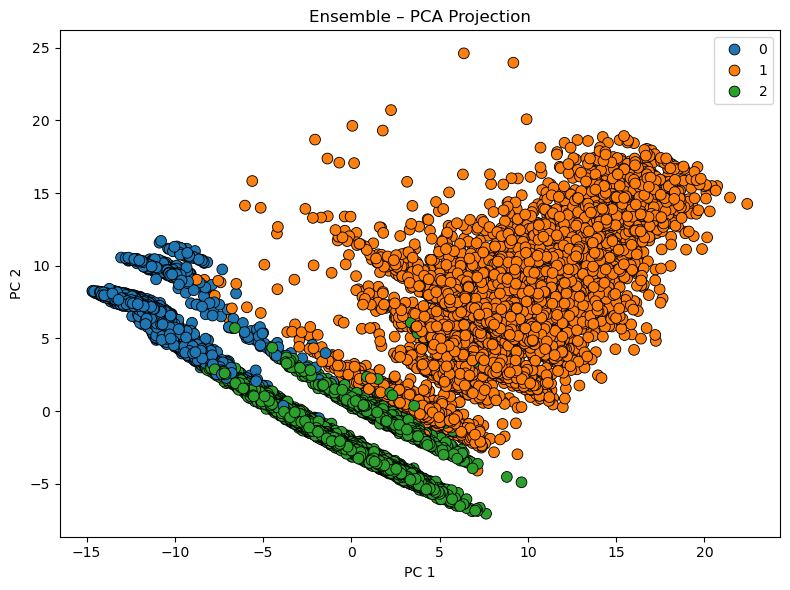

In [46]:
# PCA
plot_pca(X_scaled, labels, title="Ensemble – PCA Projection")

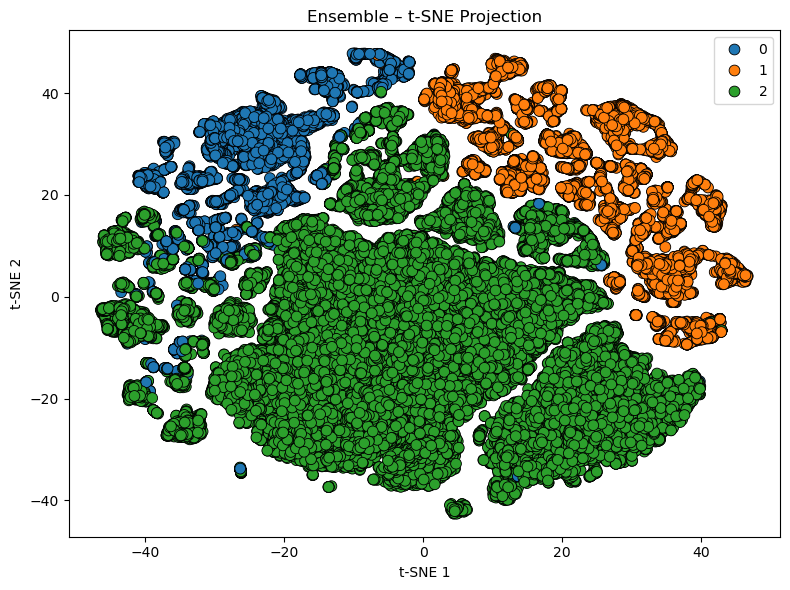

In [47]:
# t-SNE
plot_tsne(X_scaled, labels, title="Ensemble – t-SNE Projection")

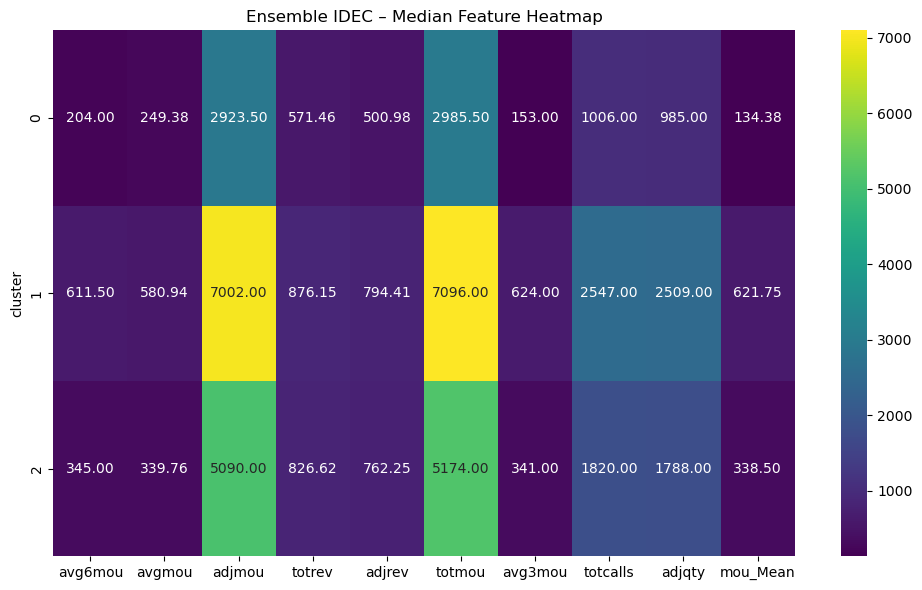

In [48]:
# Heat-map of medians
plot_cluster_heatmap(df_labeled_orig, labels, top_feats,
                     title="Ensemble IDEC – Median Feature Heatmap")

C:\Users\Eden Thomas\AppData\Local\Temp\ipykernel_11704\61327045.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="cluster", y=feat, data=dfc, palette="tab10")


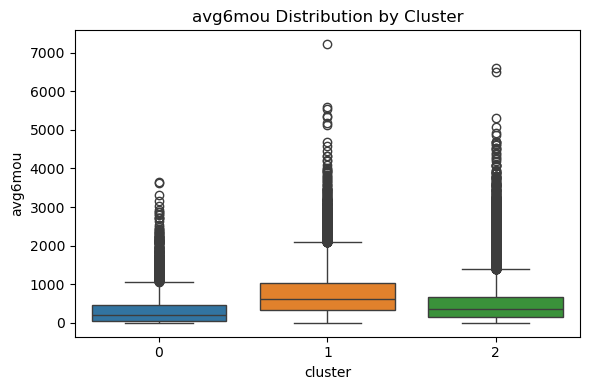

C:\Users\Eden Thomas\AppData\Local\Temp\ipykernel_11704\61327045.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="cluster", y=feat, data=dfc, palette="tab10")


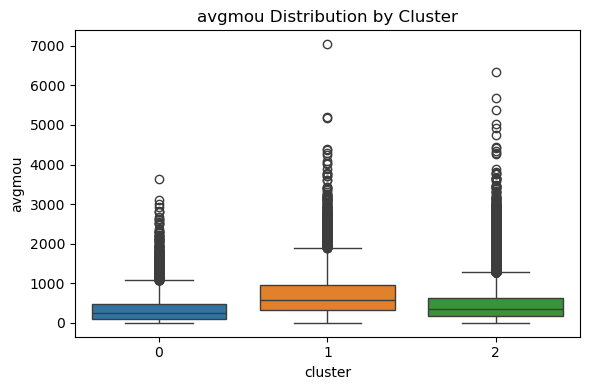

C:\Users\Eden Thomas\AppData\Local\Temp\ipykernel_11704\61327045.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="cluster", y=feat, data=dfc, palette="tab10")


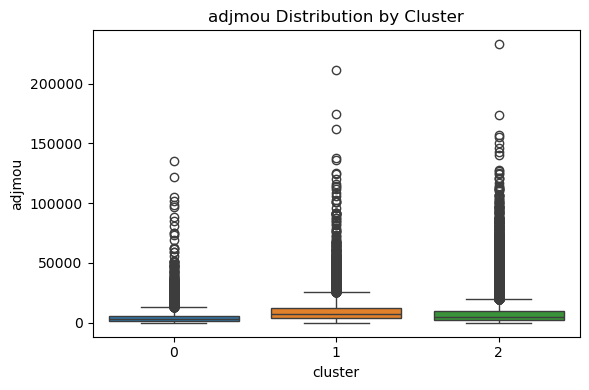

C:\Users\Eden Thomas\AppData\Local\Temp\ipykernel_11704\61327045.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="cluster", y=feat, data=dfc, palette="tab10")


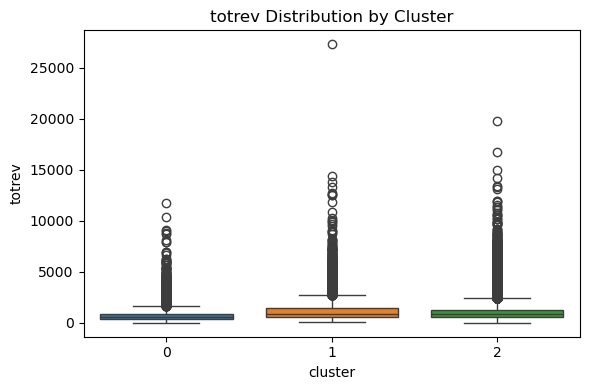

C:\Users\Eden Thomas\AppData\Local\Temp\ipykernel_11704\61327045.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="cluster", y=feat, data=dfc, palette="tab10")


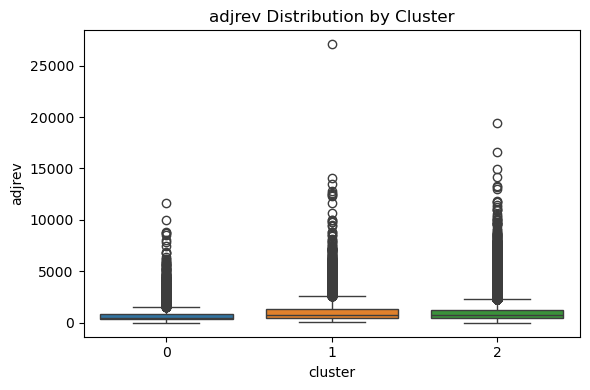

In [49]:
# Feature box-plots
plot_feature_boxplots(df_labeled_orig, labels, top_feats, n=5)

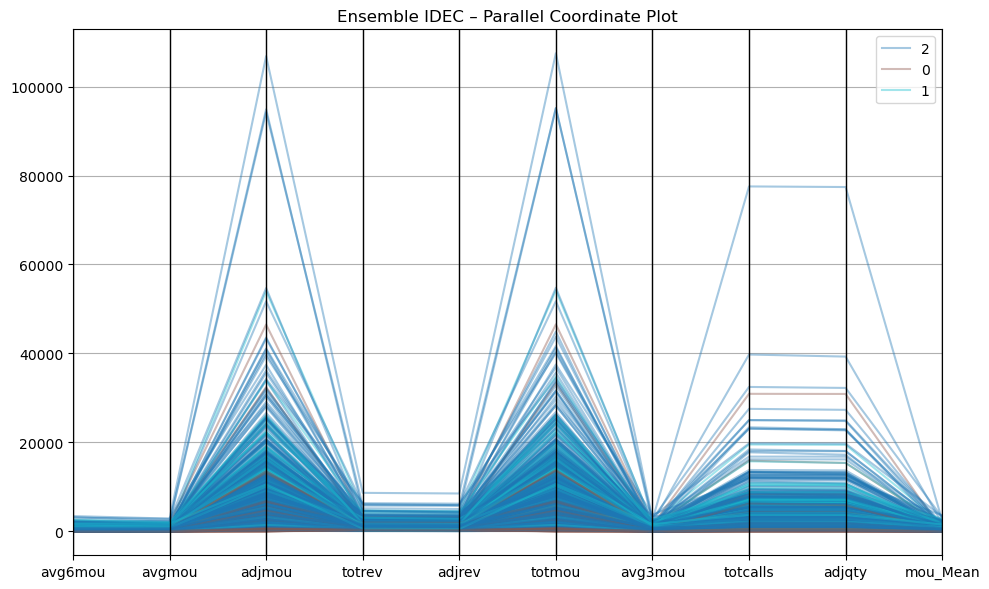

In [50]:
# Parallel coordinates
plot_parallel_coordinates(df_labeled_orig, labels, top_feats,
                          title="Ensemble IDEC – Parallel Coordinate Plot")

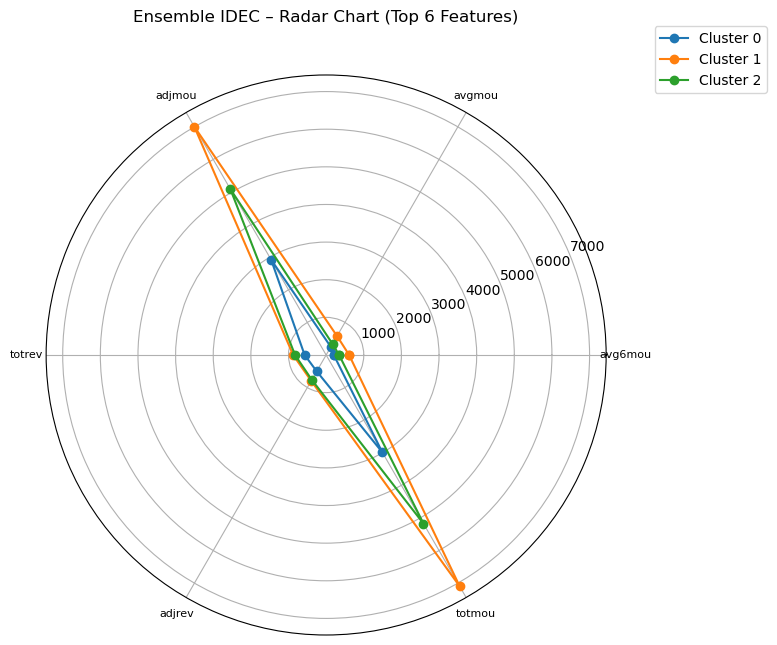

In [51]:
# Radar chart (first 6 top features)
plot_radar_chart(df_labeled_orig, labels, top_feats[:6],
                 title="Ensemble IDEC – Radar Chart (Top 6 Features)")